Initialization

In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import IPython.display as display
import pandas as pd

from core import get_img, remove_small_obj, pmap, unsharp, average_blur, grey_dilation, gaussian_blur, lowpass, highpass
from global_const import data_dir, R, C

In [2]:
images = []
data_dirs = []

for dirname in os.listdir(data_dir):
        if dirname.startswith('LuoJia1'):
            data_dirs.append(dirname)

data_dirs.sort()

used_data_dirs = np.random.choice(data_dirs, 12, replace=False)
print(used_data_dirs)


images = pmap(get_img, used_data_dirs)

['LuoJia1-01_LR201809083317_20180907211935_HDR_0020'
 'LuoJia1-01_LR201811174649_20181116212849_HDR_0029'
 'LuoJia1-01_LR201808274386_20180825210325_HDR_0026'
 'LuoJia1-01_LR201809083317_20180907212020_HDR_0029'
 'LuoJia1-01_LR201809031196_20180902210015_HDR_0012'
 'LuoJia1-01_LR201808032805_20180802213915_HDR_0046'
 'LuoJia1-01_LR201808274386_20180825210249_HDR_0019'
 'LuoJia1-01_LR201808017650_20180731205254_HDR_0038'
 'LuoJia1-01_LR201808017650_20180731205334_HDR_0046'
 'LuoJia1-01_LR201809083317_20180907212015_HDR_0028'
 'LuoJia1-01_LR201811174649_20181116212859_HDR_0031'
 'LuoJia1-01_LR201809083317_20180907212025_HDR_0030']


In [3]:
def show_img(out_img):
    display.display(Image.fromarray(out_img).convert('RGB'))
    # pass

def show_imgs(imgs, columns=None, rows=None, w=None, h=None, resize=1000, convert='L'):
    if not columns:
        columns = min(len(imgs), 3)
    if not rows:
        rows = len(imgs)//columns
    if not w:
        w = columns * 8
    if not h:
        h = rows * 8
    fig = plt.figure(figsize=(w, h))
    idx = 0
    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(Image.fromarray(imgs[idx]).resize((resize, resize)).convert(convert))
        idx += 1
    plt.show()
    # pass

def show_summary(imgs):
    stat = pd.DataFrame(np.asarray([
        np.mean(imgs, axis=(1, 2)),
        np.median(imgs, axis=(1, 2)),
        np.std(imgs, axis=(1,2))
    ]).transpose())
    stat.columns = ['mean', 'median', 'std']
    print(stat.to_string())

Load an image

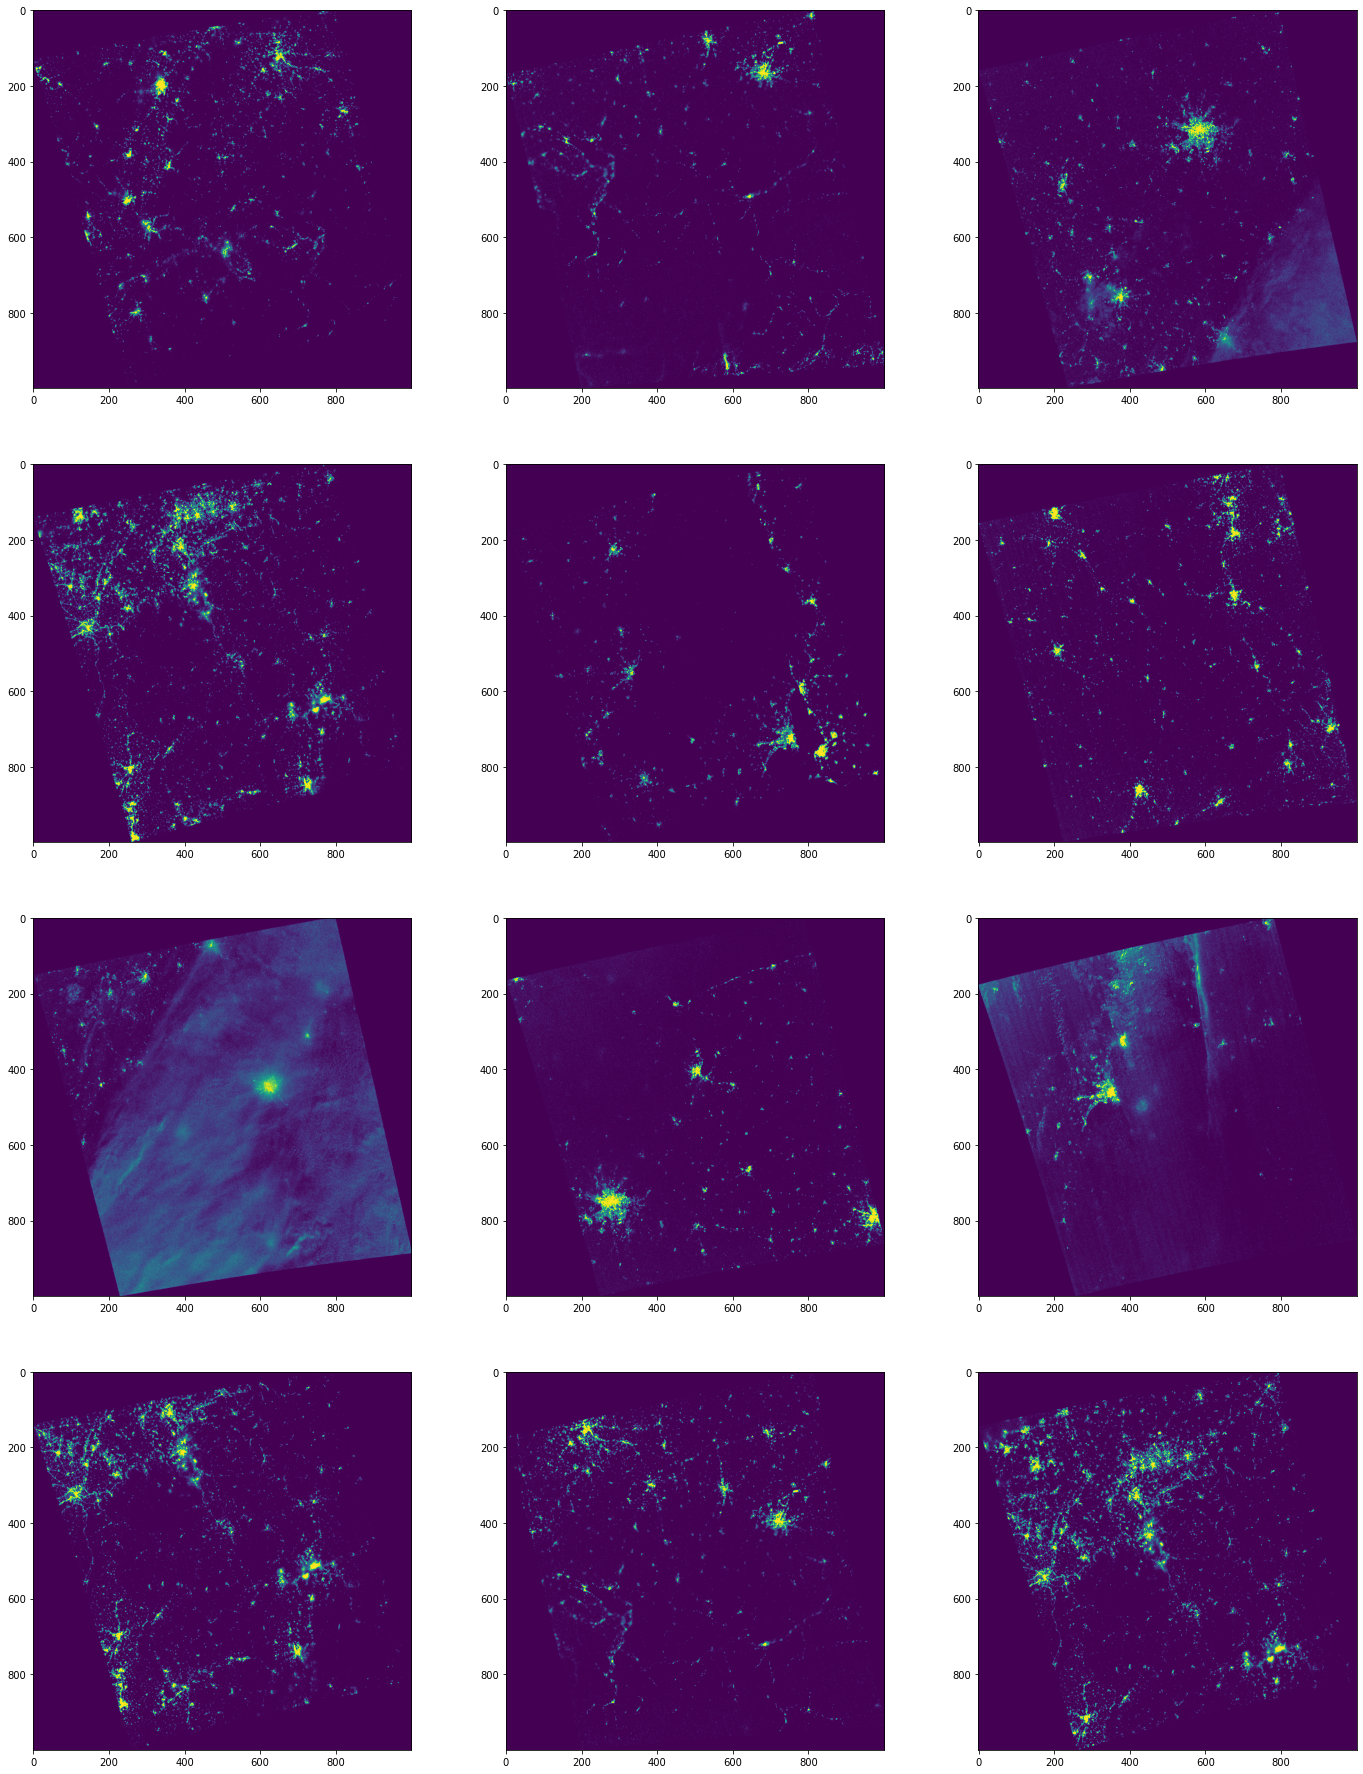

        mean    median        std
0   1.092931  0.000000   9.151389
1   0.777055  0.000000  11.444208
2   1.812216  0.017156  13.063414
3   2.616675  0.000000  33.534479
4   0.752755  0.000000   9.832663
5   1.359321  0.000000  14.588979
6   5.454016  3.860184   6.423482
7   1.158573  0.000000  12.917722
8   2.162103  0.101947   5.761801
9   2.137126  0.000000  32.580316
10  1.068351  0.000000  14.243924
11  2.414413  0.000000  19.271793


In [4]:
imgs = np.asarray(images)
out_imgs = imgs
show_imgs(out_imgs * 5)
show_summary(out_imgs)

Apply unsharp mask, streetlights are sharpened and cloud remains

In [5]:
out_imgs = pmap(unsharp, out_imgs)

Remove bright light, generate proto cloud mask

In [6]:
out_imgs = pmap(lowpass, out_imgs)

Filter out dimmer streetlights by averaging.
Kernel size should be odd

In [7]:
out_imgs = pmap(average_blur, out_imgs)

Remove noise using highpass

In [8]:
out_imgs = pmap(highpass, out_imgs)

Remove smaller areas. They are mostly noise

In [9]:
out_imgs = pmap(remove_small_obj, out_imgs).astype(np.uint8)

Try to increase the size of cloud chunks to be conservative

In [10]:
out_imgs = pmap(grey_dilation, out_imgs).astype(np.uint8)

Blur a little with gaussian filter

In [11]:
out_imgs = pmap(gaussian_blur, out_imgs).astype(np.uint8)

Adding an overlay cloud mask to original image

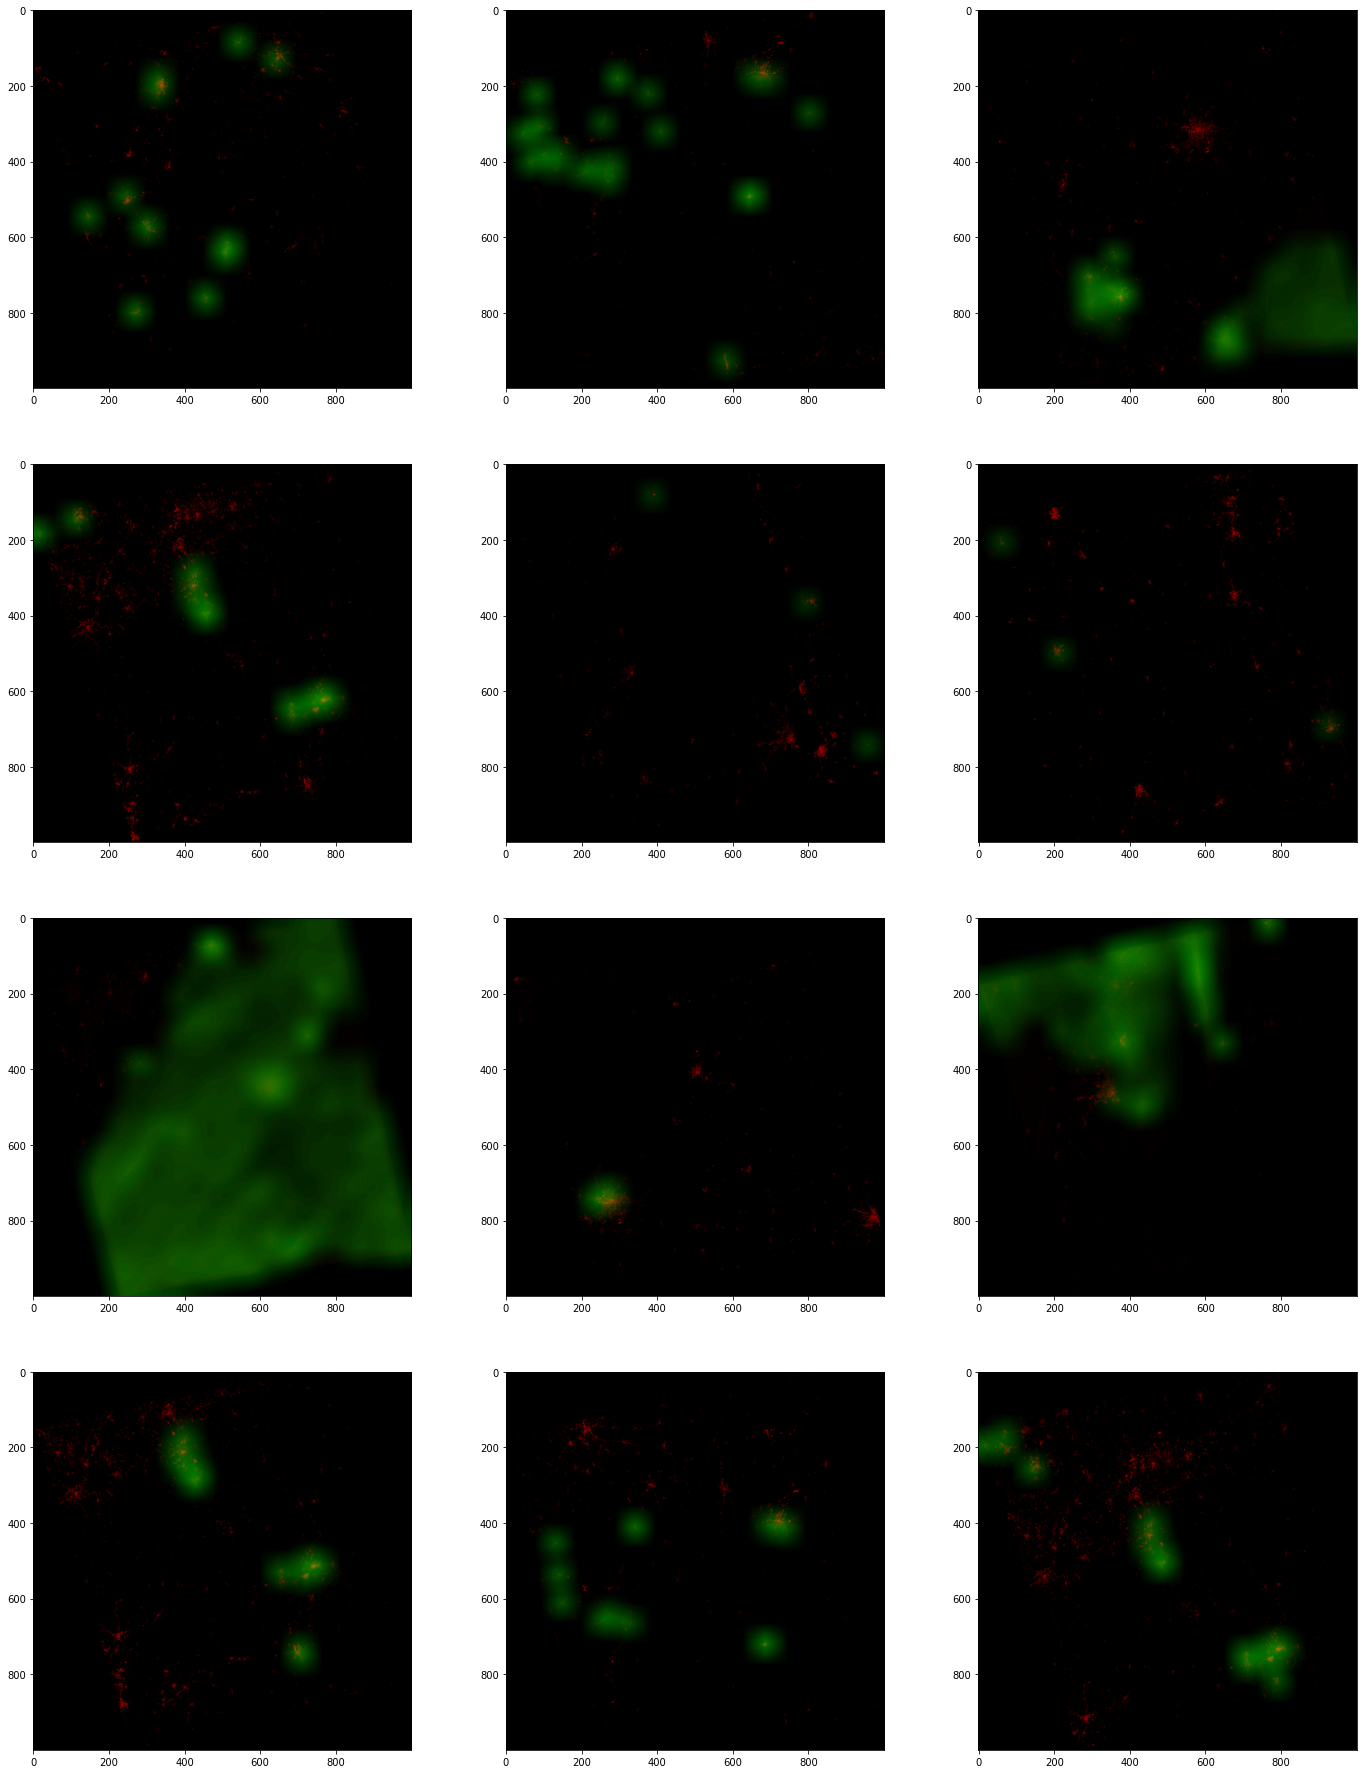

In [12]:
def safe_mult(x, v):
    shape = x.shape
    x = np.where(x <= (255//v), x, (255//v))
    x.shape = shape
    return x * v

out_imgs_rgb = []
for (img, out_img) in zip(images, out_imgs):
    out_img_rgb = np.dstack((np.uint8(np.round(img)), safe_mult(out_img, 5), np.zeros((R, C), dtype=np.uint8)))
    out_imgs_rgb.append(out_img_rgb)

show_imgs(out_imgs_rgb, convert='RGB')

Show full res image for fun

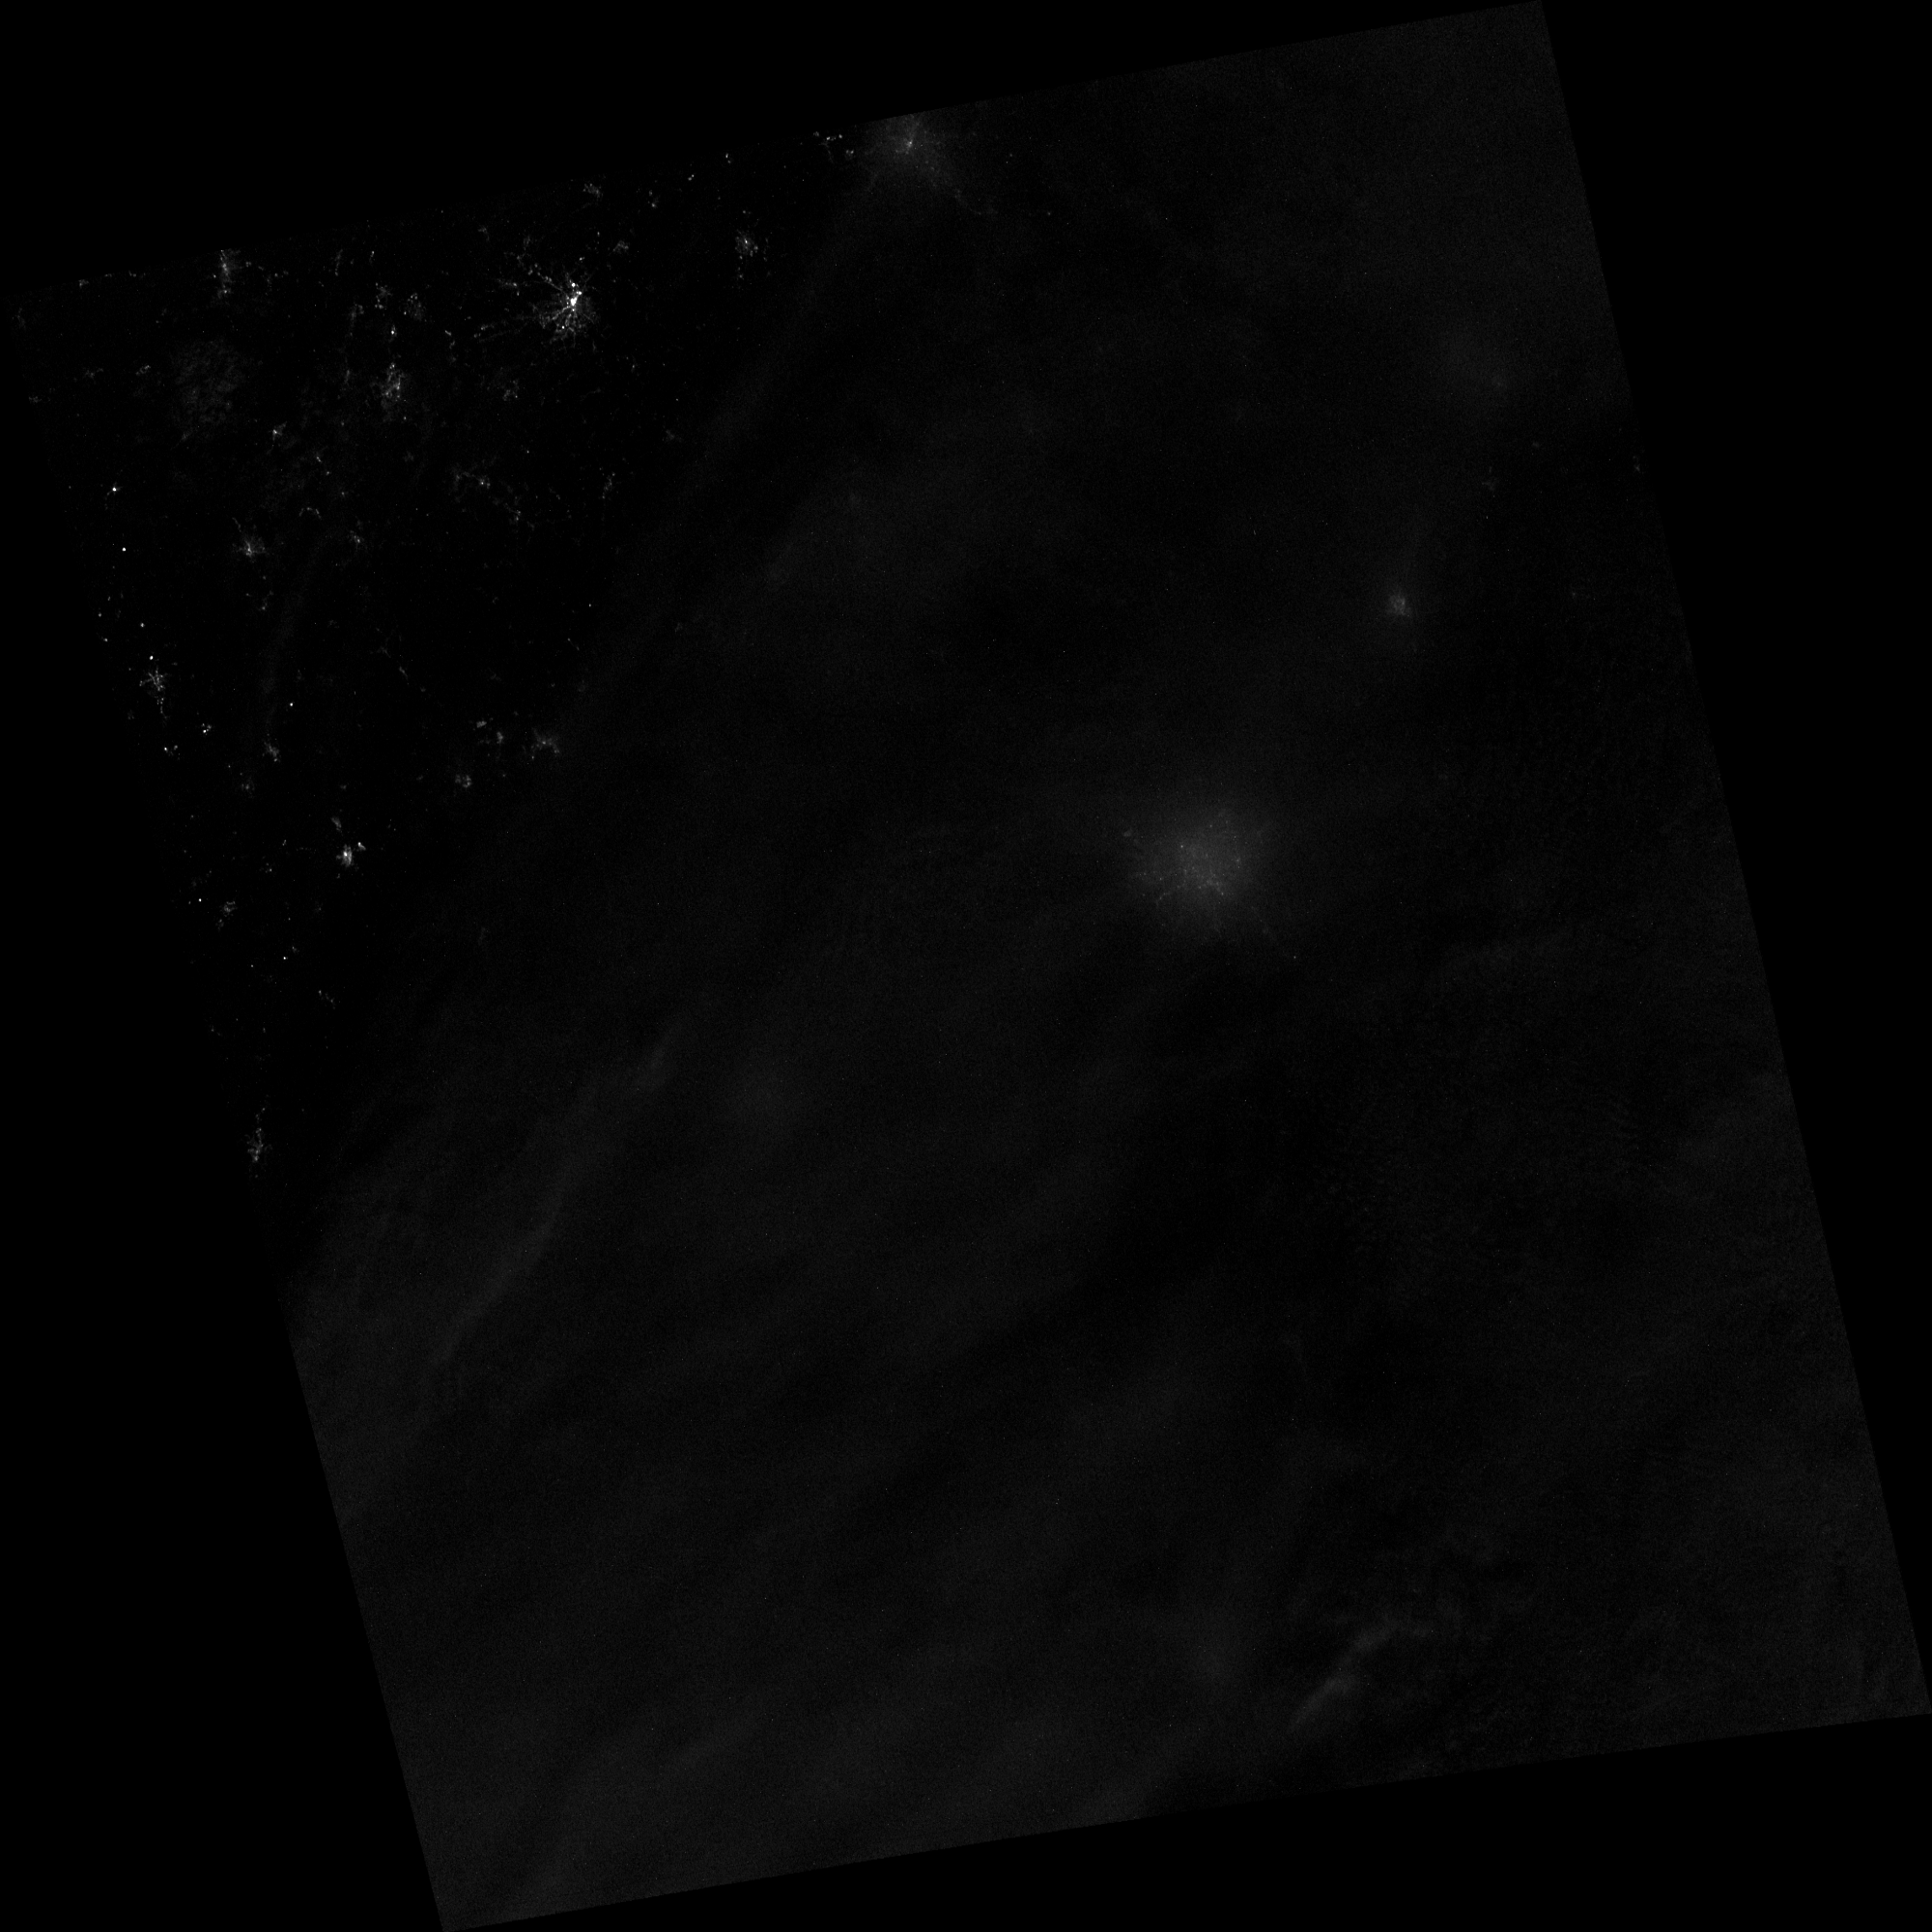

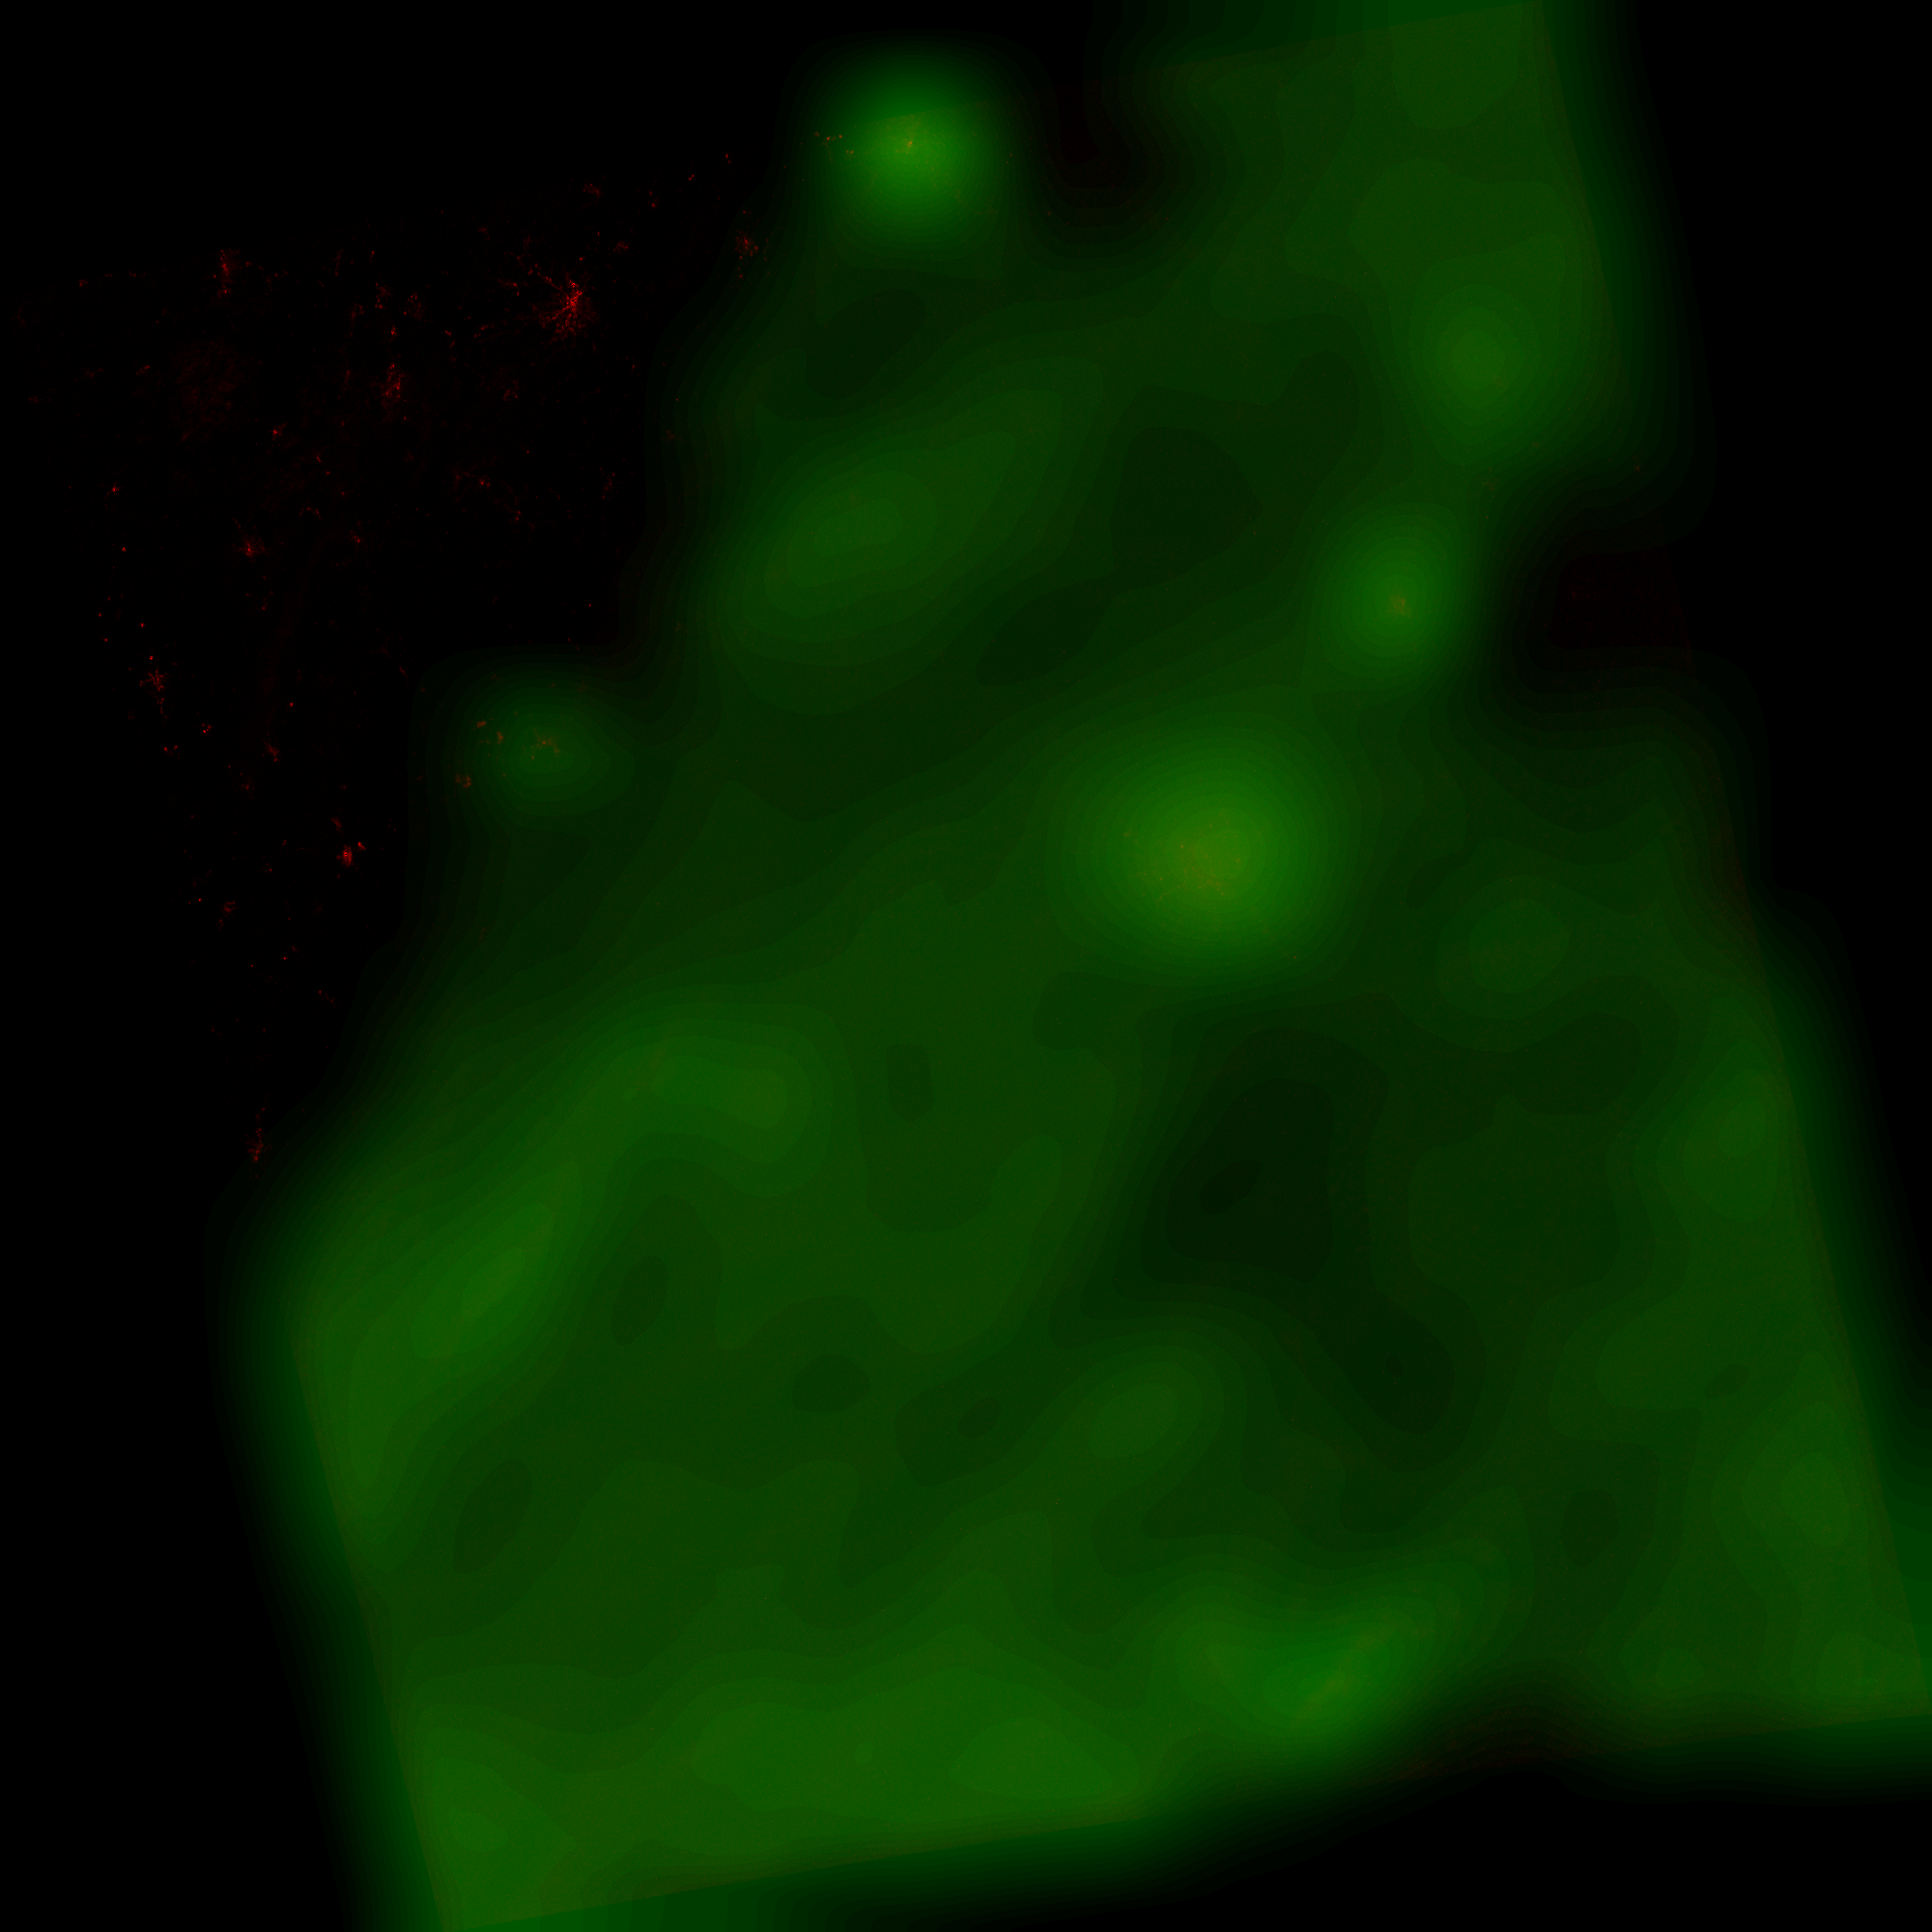

In [13]:
i = 6
show_img(images[i])
show_img(out_imgs_rgb[i])